# History-augmented Trajectory Selection

In [1]:
import numpy as np
import tqdm.auto as tqdm

from deeptime.clustering import KMeans, KMeansModel
from matplotlib import pyplot as plt
import tqdm.auto as tqdm

import MDAnalysis as mda

import copy

/Users/russojd/opt/anaconda3/envs/protein-like_msm/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/russojd/opt/anaconda3/envs/protein-like_msm/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
from deeptime.markov import TransitionCountEstimator, TransitionCountModel
from deeptime.markov.msm import MaximumLikelihoodMSM, MarkovStateModel

In [3]:
dataset_label = "strict_strat_tic_cluster_lag-10ns"

In [4]:
continuous_trajectory = mda.Universe(
    '/Users/russojd/Research/desres_trajectories/DESRES-Trajectory_2JOF-0-protein 2/2JOF-0-protein/2JOF.pdb',
    '/Users/russojd/Research/protein-like_msm/aligned_2JOF.dcd')

In [5]:
_tica = np.load(f'{dataset_label}_tica.npz', allow_pickle=True)
tica = _tica['tica']
tica_model = _tica['tica_model']
projection = _tica['projection']

In [6]:
projection.shape

(1044000, 10)

## Identify directional ensembles

### Identify macrostates

In [7]:
# Now, cluster within each of those.
# clusters_per_strat = 10
n_clusters = 1000
n_strat_bins = 10
clusters_per_strat = n_clusters // n_strat_bins

tic_rmsd = 0

tic_bins = np.linspace(-45, 15, n_strat_bins)

In [8]:
unfolded_thresh = 10#5 #0.9
folded_thresh = -35 #-1.89

unfolded = np.argwhere(projection[:, tic_rmsd].flatten() > unfolded_thresh).flatten()
folded = np.argwhere(projection[:, tic_rmsd].flatten() < folded_thresh).flatten()

In [9]:
colors = np.full(projection.shape[0], fill_value=np.nan)
literal_colors = {0:'k', 1:'g', 2:'tab:red'}

NONE = 0
UNFOLDED = 1
FOLDED = 2

colors[0] = NONE
colors[folded] = FOLDED
colors[unfolded] = UNFOLDED

last_in = colors[0]
for index, color in tqdm.tqdm(enumerate(colors), total=len(projection)):
    
    if np.isnan(color):
        colors[index] = last_in
        
    else:
        last_in = colors[index]

  0%|          | 0/1044000 [00:00<?, ?it/s]

In [10]:
switches = np.concatenate([[0], 1 + np.argwhere(colors[1:] - colors[:-1]).flatten(), [len(colors)]])

print(switches)

# But actually, stay in your color for 1 step after entering a new state
switches[1:-1] = switches[1:-1] + 1
# switches[:-1] = switches[:-1] + np.arange(len(switches[:-1]))

switches

[      0   13018   99990  131549  306481  311882  351435  352207  374979
  375326  391767  422792  519794  544023  639905  649040  650874  651270
  689960  706456  725366  746132  786661  795143  809507  830326 1032946
 1044000]


array([      0,   13019,   99991,  131550,  306482,  311883,  351436,
        352208,  374980,  375327,  391768,  422793,  519795,  544024,
        639906,  649041,  650875,  651271,  689961,  706457,  725367,
        746133,  786662,  795144,  809508,  830327, 1032947, 1044000])

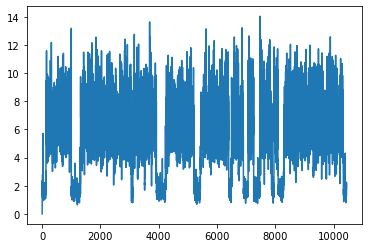

In [11]:
rmsd_trajectory = np.load(f'/Users/russojd/Research/protein-like_msm/rmsd_2JOF.npz')['rmsd']
plt.plot(rmsd_trajectory[::100])

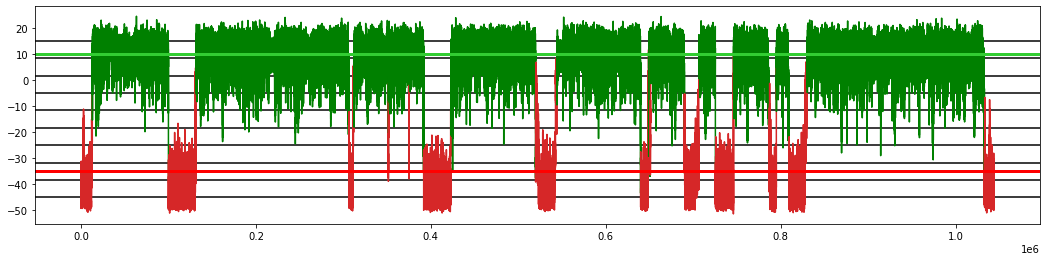

In [12]:
# tic_bins = np.linspace(-50, 20, n_strat_bins)
# tic_bins

fig, ax = plt.subplots(figsize=(18,4))

[ax.axhline(x, color='k') for x in tic_bins]
# ax.plot(projection[:, tic_rmsd], label=f'tIC {tic_rmsd}', color='tab:blue')

for start, end in np.vstack([switches[:-1], switches[1:]]).T:
    _color = literal_colors[colors[start]]
    ax.plot(np.arange(start, end), projection[start:end, tic_rmsd], label=f'tIC {tic_rmsd}', color=_color)

ax.axhline(unfolded_thresh, color='limegreen', linewidth=3)
ax.axhline(folded_thresh, color='r', linewidth=3)

Now, go back to the original trajectory, and color it.

And now find all the points where we switch over from one color to another. We'll split the trajectories at these points

Now separate out the directional ensembles

In [13]:
directional_ensembles = {color:[] for color in [NONE, FOLDED, UNFOLDED]}
mfpts = {color:[] for color in [NONE, FOLDED, UNFOLDED]}

last_time = 0
for start, end in np.vstack([switches[:-1], switches[1:]]).T:
    
    
    _color = colors[start]
    
    print(f"Segment in {int(_color):d} from {start} to {end}")
    
    mfpts[_color].append([end - start])
          
    times = np.arange(start, end)
    segment = projection[start:end]
    
    directional_ensembles[_color].append(np.array([times, segment.T]))

Segment in 2 from 0 to 13019
Segment in 1 from 13019 to 99991
Segment in 2 from 99991 to 131550
Segment in 1 from 131550 to 306482
Segment in 2 from 306482 to 311883
Segment in 1 from 311883 to 351436
Segment in 2 from 351436 to 352208
Segment in 1 from 352208 to 374980
Segment in 2 from 374980 to 375327
Segment in 1 from 375327 to 391768
Segment in 2 from 391768 to 422793
Segment in 1 from 422793 to 519795
Segment in 2 from 519795 to 544024
Segment in 1 from 544024 to 639906
Segment in 2 from 639906 to 649041
Segment in 1 from 649041 to 650875
Segment in 2 from 650875 to 651271
Segment in 1 from 651271 to 689961
Segment in 2 from 689961 to 706457
Segment in 1 from 706457 to 725367
Segment in 2 from 725367 to 746133
Segment in 1 from 746133 to 786662
Segment in 2 from 786662 to 795144
Segment in 1 from 795144 to 809508
Segment in 2 from 809508 to 830327
Segment in 1 from 830327 to 1032947
Segment in 2 from 1032947 to 1044000


/var/folders/br/39cs_vgj35b6qs4y2kdfp7dsg0d5l5/T/ipykernel_65955/1110596562.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  directional_ensembles[_color].append(np.array([times, segment.T]))


In [14]:
# FOLDED here means last-in-folded. If you're last-in-folded, and you change colors, you just underwent UNFOLDING

# Conversion: * 200 (picoseconds/frame) / 1000 (picoseconds/nanosecond) / 1000 (nanoseconds/microsecond)
convert = lambda x: x * 200 / 1000 / 1000

convert(np.mean(mfpts[FOLDED])), convert(np.mean(mfpts[UNFOLDED]))

(2.764271428571429, 13.084630769230767)

# Discretization

In [15]:
def stratified_cluster(tic_bins, projection, clusters_per_strat, tic_rmsd):

    bin_boundaries = np.concatenate([[-np.inf], tic_bins, [np.inf]])

    all_clusters = []

    # discretized = np.full(len(projection), fill_value=np.nan)
    discretized = [np.full(len(x[1][0]), fill_value=np.nan) for x in projection]
    traj_starts = np.cumsum([len(x) for x in discretized])
    print([len(x) for x in discretized])

    for i, (bin_lower, bin_upper) in tqdm.tqdm(
                                            enumerate(zip(bin_boundaries[:-1], bin_boundaries[1:])), 
                                        total=len(bin_boundaries)-1):

        kmeans_estimator = KMeans(
            n_clusters=clusters_per_strat,
            max_iter=1000,
            fixed_seed=1337,
            n_jobs=4,
            # progress=tqdm.tqdm
        )
        # print(bin_lower, bin_upper)
        
        
        # For each trajectory, get its points that fall in the current bin
        all_traj_idxs_in_bin = []
        all_traj_points_in_bin = []
        for traj_idx, (traj_time_indices, traj_projection) in enumerate(projection):
            
            # print(f"Traj shape is {traj_projection.shape}")
            assert traj_projection.shape[0] == 10
            
            # Get the indices of points in the current bin
            traj_idxs_in_bin = np.argwhere(
                (traj_projection[tic_rmsd, :] >= bin_lower) & 
                (traj_projection[tic_rmsd, :] < bin_upper)
            ).flatten()
            
            all_traj_idxs_in_bin.append(traj_idxs_in_bin)
            
            # Now also get the actual points, to make clustering easier
            all_traj_points_in_bin.append(traj_projection[:, traj_idxs_in_bin])
            
        # Now I have all the points from all the trajectories that are in the current bin
        # if len(all_traj_idxs_in_bin) == 0:
            # print(f"No trajs in this set had points in bin {i}")
            # continue
            
        # print(f"Points in bin: {len(all_traj_points_in_bin)}, with shapes {[x.shape for x in all_traj_points_in_bin]}")
        
        all_points_together = np.hstack(all_traj_points_in_bin).T
        # print(f"All together, shape is {all_points_together.shape}")
        
        if all_points_together.shape[0] == 0:
            print(f"No trajs in this set had points in bin {i}")
            continue
        
        try:
            _clustering = kmeans_estimator.fit(all_points_together).fetch_model()
            # print(_clustering.metric)
        except ValueError as e:
            print(f"Only had {len(all_points_together)} points")
            raise e
        cluster_offset = i*clusters_per_strat
        
        # Now discretize the parts of each trajectory that are in this bin
        for traj_idx in range(len(projection)):
            
            traj_idxs_in_bin = all_traj_idxs_in_bin[traj_idx]
            traj_points_in_bin = all_traj_points_in_bin[traj_idx].T
            
            # print(f"In bin, shape is {traj_points_in_bin.shape}")
            
            # print(f"Populating {discretized[traj_idx][traj_idxs_in_bin].shape}")
            # print(f"\t {discretized[traj_idx].shape}")
            
            discretized[traj_idx][traj_idxs_in_bin] = _clustering.transform(traj_points_in_bin)
            discretized[traj_idx][traj_idxs_in_bin] += cluster_offset
            
        all_clusters.append(copy.deepcopy(_clustering))

    # discrete_stratified = discretized

    combined_kmeans_centers = np.concatenate([x._cluster_centers for x in all_clusters])
    # print([len(x) for x in discretized])
    # print(discretized[0].shape)
    
    return discretized, combined_kmeans_centers, bin_boundaries

# MSM Building

## Independent haMSMs

In [23]:
def symmetrize(count_model, lag):
    
    symmetric_count_matrix = count_model.count_matrix + count_model.count_matrix.T
    symmetric_count_model = TransitionCountModel(symmetric_count_matrix, 
                                             lagtime=count_model.lagtime, counting_mode='sliding')

    symm_msm =  MaximumLikelihoodMSM(reversible=True).fit_fetch(
    symmetric_count_model.submodel_largest())

    msm = symm_msm

    return symm_msm

In [32]:
msm_lag = 5 # 10ns
print(msm_lag)

# thresholds = {FOLDED:[folded_thresh, 0], UNFOLDED:[-35, unfolded_thresh]}
# thresholds = {FOLDED:[-35, 10], UNFOLDED:[-35, 10]}


thresh = [folded_thresh, unfolded_thresh]
thresholds = {FOLDED:thresh, UNFOLDED:thresh}

direction = FOLDED
directions = ['NONE', 'Unfolding', "Folding"]

5


In [33]:
# for directional_trajectories in [directional_ensembles[direction]]:
msms = {}
all_discrete_trajectories = {}
all_kmeans = {}

# Shared discretization
   
n_clusters = 200
n_strat_bins = 10
clusters_per_strat = n_clusters // n_strat_bins

tic_rmsd = 0

# tic_threshs = {UNFOLDED:[-20, 15], FOLDED:[-45, 10]}
print(folded_thresh, unfolded_thresh)
tic_bins = np.linspace(folded_thresh, unfolded_thresh, n_strat_bins)
discrete_stratified, combined_kmeans_centers, bin_boundaries = stratified_cluster(
    tic_bins, 
    [[np.arange(len(projection)), projection.T]], 
    clusters_per_strat, tic_rmsd)

-45 15
[1044000]


  0%|          | 0/11 [00:00<?, ?it/s]

In [37]:
_folded_thresh, _unfolded_thresh = thresholds[direction]
unfolded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() > _unfolded_thresh).flatten()
folded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() < _folded_thresh).flatten()

all_active_states = {}
uncleaned_msms = {}
remapped_trajs = {}

for direction, directional_trajectories in directional_ensembles.items():
    
    print(f"Last in: {directions[direction]}")
    if len(directional_trajectories) == 0: continue
    if direction == 0: continue
    
#     discrete_stratified, combined_kmeans_centers, bin_boundaries = stratified_cluster(
#         tic_bins, directional_trajectories, clusters_per_strat, tic_rmsd)

    # discrete_trajectories = [x.astype(int) for x in discrete_stratified]
    
    # Get the discrete trajectories
    trajectory_indices = [x[0] for x in directional_trajectories]
    discrete_trajectories = [discrete_stratified[0][indices].astype(int) for indices in trajectory_indices]
    
    count_model = TransitionCountEstimator(msm_lag, 'sliding-effective').fit_fetch(discrete_trajectories)
    asymm_msm = MaximumLikelihoodMSM(reversible=False).fit_fetch(count_model.submodel_largest())

    symm_msm = asymm_msm#
    # symm_msm = symmetrize(count_model, lag)
    print(f"{symm_msm.n_states} active states")
    
    uncleaned_msms[direction] = symm_msm
    all_discrete_trajectories[direction] = discrete_trajectories
    all_kmeans[direction] = combined_kmeans_centers
    
    # active_states = np.argwhere(count_model.state_histogram).flatten()
    active_states = count_model.connected_sets()[0]
    remap = {j:i for i,j in enumerate(active_states)}
    all_active_states[direction] = active_states
    _unfolded = [remap[x] for x in unfolded if x in remap.keys()]
    _folded = [remap[x] for x in folded if x in remap.keys()]
    
    mfpt_folding = symm_msm.mfpt(_unfolded, _folded)
    mfpt_unfolding = symm_msm.mfpt(_folded, _unfolded) #mfpt_folding, mfpt_unfolding
    # print(mfpt_unfolding)
    # mfpt_unfolding = mfpt(symm_msm.transition_matrix, _unfolded, _folded, tau=msm_lag)
    # mfpt_folding = mfpt(symm_msm.transition_matrix, _folded, _unfolded, tau=msm_lag)
    # print(mfpt_unfolding)
    
    print('*** Pre-cleaning')
    # MFPT are in units of the input trajectory time
    print(f"Folding time: {mfpt_folding * 200 * 100 / 1000:.2f} ns")
    print(f"Folding steps: {mfpt_folding :.0f} steps\n")

    print(f"Unfolding time: {mfpt_unfolding * 200 * 100 / 1000:.2f} ns")
    print(f"Unfolding steps: {mfpt_unfolding :.0f} steps")
    # ~500 steps @ 200ps/step = 0.1µs

Last in: NONE
Last in: Folding
186 active states


ValueError: zero-size array to reduction operation maximum which has no identity

In [29]:
minimum_set = np.intersect1d(*[x.count_model.connected_sets()[0] for x in uncleaned_msms.values()])

msms = {}
# remaps = {}
# remapped_discrete_trajectories = {}
for key, value in uncleaned_msms.items():
    
    msms[key] = value.submodel(minimum_set)
    
    # remap = {old_state_index:consecutive_index for consecutive_index, old_state_index in 
    #          enumerate(msms[key].count_model.connected_sets()[0])}
    # remaps[key] = remap

### Build the structure map

In [30]:
# For all directions, get representative structures for each cluster
structure_maps = {}
remapped_directional_ensembles = {}
remaps = {}
all_active_states = {}

n_total_states = None
for direction, directional_trajectories in directional_ensembles.items():
    
    
    if direction == NONE: continue
    
    print(f"Processing direction {directions[direction]}")
    
    discrete_trajectories = all_discrete_trajectories[direction]
    
    # Get the indices of the points in each bin
    time_indices = [x[0] for x in directional_trajectories]
    
    n_states = msms[direction].transition_matrix.shape[0]
    print(f"{n_states} states")
    
    active_states = msms[direction].count_model.connected_sets()[0]
    all_active_states[direction] = active_states
    # Maps non-consecutive states to their consecutive indices
    consecutive_states = {}
    for consecutive_index, original_index in enumerate(np.unique([ i for sl in discrete_trajectories for i in sl])):
#     for i, j in enumerate(msms[direction].count_model.connected_sets()[0]):
        consecutive_states[original_index] = consecutive_index
    
        
    remaps[direction] = consecutive_states
        
    remapped_trajectories = [np.array([consecutive_states[x] for x in traj], dtype=int) 
                             for traj in discrete_trajectories]
    
#     remapped_directional_ensembles[direction] = remapped_trajectories
        
    # print(n_states, len(consecutive_states))
    # assert len(consecutive_states) == n_states
    
    structure_map = {}
    # Now pick a representative structure for each cluster
    # for cluster_idx in range(n_states):
    for cluster_idx in active_states:
        
        # state_idx = consecutive_states[cluster_idx]
        
        # First, find all points in this cluster
        indices_in_cluster = []
        for i, traj in enumerate(remapped_trajectories):
        # for i, traj in enumerate(discrete_trajectories):
            in_cluster = np.argwhere(traj == cluster_idx).flatten()
            indices_in_cluster.extend([i, x] for x in in_cluster)
            
        if len(indices_in_cluster) == 0:
            print(f'No structures in cluster {cluster_idx} for direction {direction}')
            continue

        # Now, randomly pick one as representative
        random = indices_in_cluster[np.random.choice(np.arange(len(indices_in_cluster)))]
        
        # And get its index in the full trajectory
        representative_index = directional_trajectories[random[0]][0][random[1]]
        
        representative_structure = continuous_trajectory.trajectory[representative_index].positions
        
        structure_map[cluster_idx] = [representative_structure, None, representative_index]
    
    structure_maps[direction] = structure_map

Processing direction Folding
182 states
Processing direction Unfolding
182 states


In [31]:
# Define slightly less-restrictive macrostates, so that each haMSM includes some from the other macrostate
# These states are initially defined as their k-means center indices. 
# So, I need to reduce down into the active-state space.

all_folded = {}
all_unfolded = {}

# thresh = [-38, 10]
thresh = [folded_thresh, unfolded_thresh]
# thresholds = {FOLDED:[-20, 0], UNFOLDED:[-20, 0]}
thresholds = {FOLDED:thresh, UNFOLDED:thresh}

for direction, remap in remaps.items():
    
    _folded_thresh, _unfolded_thresh = thresholds[direction]
    unfolded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() > _unfolded_thresh).flatten()
    folded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() < _folded_thresh).flatten()
    
    # Problem: Unfolded clusters don't contain any folded states
    print(folded)
    print(unfolded)
    
    # _folded = [remap[x] for x in folded if x in remap.keys() and x in all_active_states[direction]]
    # _unfolded = [remap[x] for x in unfolded if x in remap.keys() and x in all_active_states[direction]]
    
    _folded = [remap[x] for x in folded if x in remap.keys()]
    _unfolded = [remap[x] for x in unfolded if x in remap.keys()]
    
    _folded = [x for x in _folded if x in all_active_states[direction]]
    _unfolded = [x for x in _unfolded if x in all_active_states[direction]]
    
    print(_folded)
    print(_unfolded)
    print('\n\n')
    
    all_folded[direction] = _folded
    all_unfolded[direction] = _unfolded

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[]



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
[0, 1, 2, 3, 4, 5, 6, 7]
[176, 177, 178, 179, 180, 181]





In [943]:
np.savez('built_hamsm', 
         msms=msms,
         structure_maps=structure_maps,
         # combined_structure_map=combined_structure_map,
         all_kmeans=all_kmeans,
         tic_rmsd=tic_rmsd,
         all_folded=all_folded,
         all_unfolded=all_unfolded,
         all_active_states=all_active_states
        )

In [942]:
for direction, msm in msms.items():
    
    _unfolded, _folded = all_unfolded[direction], all_folded[direction]
    
    mfpt_folding = msm.mfpt(_unfolded, _folded)
    mfpt_unfolding = msm.mfpt(_folded, _unfolded) #mfpt_folding, mfpt_unfolding

    print('***')
    print(f"Folding time: {mfpt_folding * 200 * 10 / 1000:.2f} ns")
    print(f"Folding steps: {mfpt_folding :.0f} steps\n")

    print(f"Unfolding time: {mfpt_unfolding * 200 * 10  / 1000:.2f} ns")
    print(f"Unfolding steps: {mfpt_unfolding :.0f} steps\n\n")

# mfpt_folding, mfpt_unfolding

# print(f"Folding time: {mfpt_folding * 200 * 10 / 1000:.2f} ns")
# print(f"Folding steps: {mfpt_folding :.0f} steps\n")

# print(f"Unfolding time: {mfpt_unfolding * 200 * 10  / 1000:.2f} ns")
# print(f"Unfolding steps: {mfpt_unfolding :.0f} steps")
# ~500 steps @ 200ps/step = 0.1µs
# These MFPTs seem super high?

***
Folding time: 6911.71 ns
Folding steps: 3456 steps

Unfolding time: 95914.24 ns
Unfolding steps: 47957 steps


***
Folding time: 193938.14 ns
Folding steps: 96969 steps

Unfolding time: 2502.05 ns
Unfolding steps: 1251 steps




## 2Nx2N combined haMSM

**NOTE**: This section is VERY non-idempotent.. run from here to be safe!

To build the 2-direction, N-states haMSM as a combined matrix, we want to build a 2Nx2N matrix.

1. Discretize the two directional ensembles independently
2. Clean them, restricting them only to the shared active set
3. Reindex the N states so direction 1 are 0-N, and direction 2 are N-2N
4. Apply that discretization to the full trajectory, so it's discretized over 2N states
5. Build a shared structure map
    The structure map should be indexed as `[state_index%N]`

In [211]:
def transform_stratified(cluster_centers, projection, tic_bins, tic_rmsd):
    

    bin_boundaries = np.concatenate([[-np.inf], tic_bins, [np.inf]])

    # all_clusters = []

    discretized = [np.full(len(x[1][0]), fill_value=np.nan) for x in projection]
    traj_starts = np.cumsum([len(x) for x in discretized])
    # print([len(x) for x in discretized])
    
    cluster_offset = 0

    for i, (bin_lower, bin_upper) in tqdm.tqdm(
                                            enumerate(zip(bin_boundaries[:-1], bin_boundaries[1:])), 
                                        total=len(bin_boundaries)-1):

        # Make a KMeans estimator using only the cluster centers in this bin
        center_idxs_in_bin = np.argwhere(
            (cluster_centers[:, tic_rmsd] >= bin_lower) & 
            (cluster_centers[:, tic_rmsd] < bin_upper)
        ).flatten()
        
        _clustering = KMeansModel(
            cluster_centers[center_idxs_in_bin],
            metric="euclidean",
            # fixed_seed=True
        )
        print(f"{center_idxs_in_bin.shape} centers in bin")
        
        
        # For each trajectory, get its points that fall in the current bin
        all_traj_idxs_in_bin = []
        all_traj_points_in_bin = []
        for traj_idx, (traj_time_indices, traj_projection) in enumerate(projection):
            
            # print(f"Traj shape is {traj_projection.shape}")
            assert traj_projection.shape[0] == 10
            
            # Get the indices of points in the current bin
            traj_idxs_in_bin = np.argwhere(
                (traj_projection[tic_rmsd, :] >= bin_lower) & 
                (traj_projection[tic_rmsd, :] < bin_upper)
            ).flatten()
            
            all_traj_idxs_in_bin.append(traj_idxs_in_bin)
            
            if len(traj_idxs_in_bin) > 0:
                
                assert len(_clustering._cluster_centers) > 0, f"Trajs but no cluster centers in bin {i}! {bin_lower} = {bin_upper}"
            
            # Now also get the actual points, to make clustering easier
            all_traj_points_in_bin.append(traj_projection[:, traj_idxs_in_bin])
        
        all_points_together = np.hstack(all_traj_points_in_bin).T
        # print(f"All together, shape is {all_points_together.shape}")
        
        if all_points_together.shape[0] == 0:
            print(f"No trajs in this set had points in bin {i}")
            continue
        
        # Now discretize the parts of each trajectory that are in this bin
        for traj_idx in range(len(projection)):
            
            traj_idxs_in_bin = all_traj_idxs_in_bin[traj_idx]
            traj_points_in_bin = all_traj_points_in_bin[traj_idx].T
            
            # print(f"{traj_idxs_in_bin.shape} points in bin {i}")
            
            transformed = _clustering.transform(traj_points_in_bin) + cluster_offset
            
            # print(transformed)
            
            discretized[traj_idx][traj_idxs_in_bin] = transformed
            
        cluster_offset += len(_clustering.cluster_centers)
        # print(f"Cluster offset is now {}")
    
    return discretized, combined_kmeans_centers, bin_boundaries

In [238]:
def remap_trajectory(directional_ensembles, full_trajectory, n_centers):
    
    rediscretized_full = full_trajectory.copy()
    
    offset = 0
    for direction, directional_trajectories in directional_ensembles.items():

        # print(f"Last in: {directions[direction]}")
        if len(directional_trajectories) == 0: continue
        if direction == 0: continue

        trajectory_indices = [x[0] for x in directional_trajectories]
        rediscretized_full[
            [i for sl in trajectory_indices for i in sl]] += offset * n_centers

        offset += 1
        
    return rediscretized_full

### Discretize the two directional ensembles separately

In [379]:
all_discrete_trajectories = {}
all_kmeans = {}

# Shared discretization
msm_lag = 5 # 5 steps = 10 ns
   
n_clusters = 1000
n_strat_bins = 24
clusters_per_strat = n_clusters // (n_strat_bins+1)

tic_rmsd = 0

# tic_threshs = {UNFOLDED:[-20, 15], FOLDED:[-45, 10]}
# print(folded_thresh, unfolded_thresh)
# tic_bins = np.linspace(folded_thresh, unfolded_thresh, n_strat_bins)

tic_thresh = [-50, 20]
tic_bins = np.linspace(*tic_thresh, n_strat_bins)

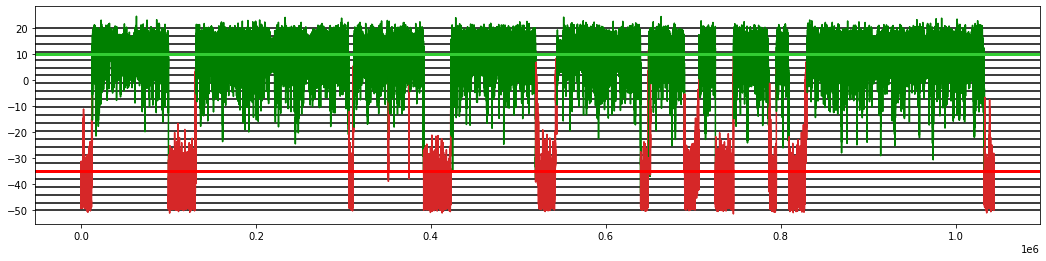

In [380]:
fig, ax = plt.subplots(figsize=(18,4))

[ax.axhline(x, color='k') for x in tic_bins]
# ax.plot(projection[:, tic_rmsd], label=f'tIC {tic_rmsd}', color='tab:blue')

for start, end in np.vstack([switches[:-1], switches[1:]]).T:
    _color = literal_colors[colors[start]]
    ax.plot(np.arange(start, end), projection[start:end, tic_rmsd], label=f'tIC {tic_rmsd}', color=_color)

ax.axhline(unfolded_thresh, color='limegreen', linewidth=3)
ax.axhline(folded_thresh, color='r', linewidth=3)

In [381]:
discrete_stratified, combined_kmeans_centers, bin_boundaries = stratified_cluster(
    tic_bins, 
    [[np.arange(len(projection)), projection.T]], 
    clusters_per_strat, tic_rmsd)

[1044000]


  0%|          | 0/25 [00:00<?, ?it/s]

In [382]:
combined_kmeans_centers.shape

(1000, 10)

The goal of this is just to build the count matrices on the initial attempt at discretizing the trajectory, so we can compare active states

In [383]:
# _folded_thresh, _unfolded_thresh = thresholds[direction]
# unfolded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() > _unfolded_thresh).flatten()
# folded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() < _folded_thresh).flatten()
unfolded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() > unfolded_thresh).flatten()
folded = np.argwhere(combined_kmeans_centers[:, tic_rmsd].flatten() < folded_thresh).flatten()
directions=["last-in-none", "last-in-unfolded", "last_in_folded"]

all_active_states = {}
uncleaned_countmodels = {}
remapped_trajs = {}

# 

for direction, directional_trajectories in directional_ensembles.items():
    
    print(f"Last in: {directions[direction]}")
    if len(directional_trajectories) == 0: continue
    if direction == 0: continue
    
#     discrete_stratified, combined_kmeans_centers, bin_boundaries = stratified_cluster(
#         tic_bins, directional_trajectories, clusters_per_strat, tic_rmsd)

    # discrete_trajectories = [x.astype(int) for x in discrete_stratified]
    
    # Get the discrete trajectories
    trajectory_indices = [x[0] for x in directional_trajectories]
    discrete_trajectories = [discrete_stratified[0][indices].astype(int) for indices in trajectory_indices]
    
    count_model = TransitionCountEstimator(msm_lag, 'sliding').fit_fetch(discrete_trajectories)
    # asymm_msm = MaximumLikelihoodMSM(reversible=False).fit_fetch(count_model.submodel_largest())
    # symm_msm = asymm_msm
    # print(f"{count_model.n_states} active states")
    
    uncleaned_countmodels[direction] = count_model
    all_discrete_trajectories[direction] = discrete_trajectories
    all_kmeans[direction] = combined_kmeans_centers
    
    active_states = count_model.connected_sets()[0]
    print(len(active_states))
    all_active_states[direction] = active_states

Last in: last-in-none
Last in: last_in_folded
682
Last in: last-in-unfolded
655


### Build 2Nx2N haMSM

#### Aggro cleaning

Another round of cleaning, this time on the shared states

Requires active states to be active in BOTH

#### Less aggro cleaning

I thought htis would be way more involved -- actually all it requires is changing the intersect to a union at the beginning

In [384]:
##### Initial rediscretization
import numpy as np
rng = np.random.default_rng(seed=1)
# minimum_set_kmeans_centers = combined_kmeans_centers.copy()

# del minimum_set, n_shared_states, rediscretized_full 
# del count_model, disconnected_states_remain
# del minimum_set_kmeans_centers

#### First, clean any states which aren't active in EITHER
minimum_set = np.union1d(*[x.connected_sets()[0] for x in uncleaned_countmodels.values()])
n_shared_states = len(minimum_set)
print(minimum_set, minimum_set.shape)

minimum_set_kmeans_centers = combined_kmeans_centers[minimum_set]

rediscretized_full, _, _ = transform_stratified(
    minimum_set_kmeans_centers, 
    [[np.arange(len(projection)), projection.T]], 
    tic_bins, 
    tic_rmsd)
rediscretized_full = rediscretized_full[0].astype(int)

rediscretized_full = remap_trajectory(directional_ensembles, rediscretized_full, n_centers = combined_kmeans_centers.shape[0])

count_model = TransitionCountEstimator(msm_lag, 'sliding').fit_fetch(rediscretized_full)
disconnected_states_remain = len(count_model.connected_sets()) > 1

n_shared_states = minimum_set_kmeans_centers.shape[0]

disconnected_states_remain = False
while disconnected_states_remain:
    print(f"Attempting cleaning, {sum([len(x) for x in count_model.connected_sets()[1:]])} (2N) unclean states ({count_model.n_states} total (2N))")
    print(count_model.connected_sets()[1:])

    # Identify the shared, active states (in the 1N state-space)
    # Is this necessary? Maybe this is too aggressively cleaning
    all_clean_combined_states = count_model.connected_sets()[0]
    clean_combined_states, counts = np.unique(all_clean_combined_states % n_shared_states, return_counts=True)
    clean_combined_states = clean_combined_states[counts > 1]
    # clean_combined_states = clean_combined_states[counts > 0]
    # clean_combined_states = all_clean_combined_states
    
    # Require at least one cluster in each bin post-cleaning
    force_preserve = []
    for i, (_bin_lower, _bin_upper) in enumerate(zip(bin_boundaries[:-1], bin_boundaries[1:])):
        # print(i, _bin_lower, _bin_upper)
        
        original_centers_in_bin = np.argwhere(
            (minimum_set_kmeans_centers[:, tic_rmsd] < _bin_upper) &
            (minimum_set_kmeans_centers[:, tic_rmsd] > _bin_lower)).flatten()
        # print(original_centers_in_bin)
        
        clean_centers_in_bin = np.argwhere(
            (minimum_set_kmeans_centers[clean_combined_states, tic_rmsd] < _bin_upper) &
            (minimum_set_kmeans_centers[clean_combined_states, tic_rmsd] > _bin_lower)).flatten()
        
        if len(clean_centers_in_bin) == 0:
            to_keep = rng.choice(original_centers_in_bin, size=max(len(original_centers_in_bin)-1,1))
            
            force_preserve.extend(to_keep)
            print(_bin_upper, _bin_lower)
            print(f"Cleaning would remove all centers in bin {i}, keeping state {to_keep}")
            
    clean_combined_states = np.concatenate([clean_combined_states, force_preserve]) 
    print(f"{len(clean_combined_states)} (1N) clean states identified (all: {len(all_clean_combined_states)})")
    
    # Rediscretize with those
    minimum_set_kmeans_centers = minimum_set_kmeans_centers[clean_combined_states]
    shared_minimum_clustering = KMeansModel(minimum_set_kmeans_centers, metric='euclidean')
    
    rediscretized_full, _, _ = transform_stratified(
        minimum_set_kmeans_centers, 
        [[np.arange(len(projection)), projection.T]], 
        tic_bins, 
        tic_rmsd)
    rediscretized_full = rediscretized_full[0].astype(int)
    rediscretized_full = remap_trajectory(directional_ensembles, rediscretized_full, n_centers = minimum_set_kmeans_centers.shape[0])
        
        
    count_model = TransitionCountEstimator(msm_lag, 'sliding').fit_fetch(rediscretized_full)
    disconnected_states_remain = len(count_model.connected_sets()) > 1 + len(force_preserve)
    
    n_shared_states = minimum_set_kmeans_centers.shape[0]
    
print("Finished cleaning")

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

  0%|          | 0/25 [00:00<?, ?it/s]

(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
(40,) centers in bin
Finished cleaning


In [385]:
count_matrix = count_model.count_matrix

row_sums = count_matrix.sum(axis=1)
transition_matrix = np.divide(count_matrix.T, 
                              row_sums, 
                              out=np.zeros_like(count_matrix), 
                              where=row_sums>0).T

In [386]:
# hamsm = MaximumLikelihoodMSM(reversible=False).fit_fetch(
#     count_model
# )
full_hamsm = MarkovStateModel(transition_matrix, lagtime=msm_lag, transition_matrix_tolerance=1)

In [387]:
# I can define the haMSM over JUST the good states

good_states = count_model.connected_sets()[0]
state_was_good = np.isin(np.arange(transition_matrix.shape[0]), good_states)

hamsm = MarkovStateModel(
    transition_matrix[good_states][:,good_states], 
    lagtime=msm_lag, transition_matrix_tolerance=1)

In [388]:
full_state_stationary = np.zeros_like(transition_matrix[0]) 
full_state_stationary[state_was_good] = hamsm.stationary_distribution

Last-in-unfolded probability sum: 0.81465291539541


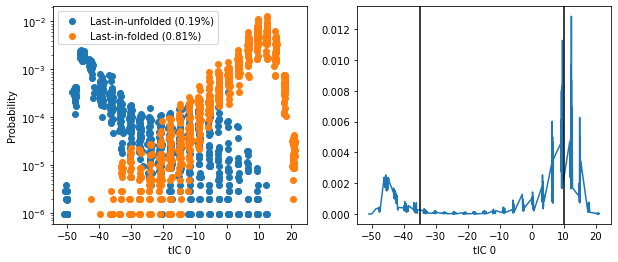

In [389]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

_sort = np.argsort(minimum_set_kmeans_centers[:,0])



# Direction 1: Last-in-unfolded
last_unfolded = full_state_stationary[0:n_shared_states][_sort]
ax[0].scatter(minimum_set_kmeans_centers[_sort,0], 
           last_unfolded, label=f'Last-in-unfolded ({sum(last_unfolded):.2f}%)')

# Direction 2: Last-in-folded
last_folded = full_state_stationary[n_shared_states:n_shared_states*2][_sort]
ax[0].scatter(minimum_set_kmeans_centers[_sort,0],
          last_folded , label=f'Last-in-folded ({sum(last_folded):.2f}%)')

print(f"Last-in-unfolded probability sum: {sum(full_state_stationary[n_shared_states:n_shared_states*2])}")
           
ax[0].legend()
ax[0].set_yscale('log')

# Equilibrium
equil = full_state_stationary[n_shared_states:n_shared_states*2] +\
    full_state_stationary[0:n_shared_states]
ax[1].plot(minimum_set_kmeans_centers[_sort,0], equil[_sort])

ax[0].set_xticks([-50, -40, -30, -20, -10, 0, 10, 20])
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('tIC 0')
ax[1].set_xlabel('tIC 0')

ax[1].axvline(folded_thresh, color='k')
ax[1].axvline(unfolded_thresh, color='k')

## 2Nx2N shared structure map

Build one structure map going both directions

In [390]:
structure_map = {}

for state in range(n_shared_states):
    
    # Get indices of points in this cluster, in EITHER direction
    indices = np.argwhere(rediscretized_full % n_shared_states == state).flatten()
    
    random_index = np.random.choice(indices)
    
    representative_structure = continuous_trajectory.trajectory[random_index].positions
    
    structure_map[state] = [representative_structure, None, random_index]
    structure_map[state + n_shared_states] = [representative_structure, None, random_index]

# Check MFPT

In [391]:
# Map good states to their consecutive index in the new haMSM
good_map = {j:i for i, j in enumerate(good_states)}

In [392]:
_unfolded = np.argwhere(minimum_set_kmeans_centers[:,0] > unfolded_thresh).flatten()
_folded = np.argwhere(minimum_set_kmeans_centers[:,0] < folded_thresh).flatten()

# This gives me the unfolded states in the 2N representation
# But which of the 2N states survived to the haMSM? Keep only those
full_both_direction_unfolded = np.intersect1d(
    np.concatenate([_unfolded, _unfolded + n_shared_states]),
    good_states
)
# both_direction_folded = np.concatenate([_folded, _folded + n_shared_states])
full_both_direction_folded = np.intersect1d(
    np.concatenate([_folded, _folded + n_shared_states]),
    good_states
)

# Now, only keep those that are actually present in the hamsm
both_direction_unfolded = [good_map[x] for x in full_both_direction_unfolded if x in good_map.keys()]
both_direction_folded = [good_map[x] for x in full_both_direction_folded if x in good_map.keys()]

In [393]:
mfpt_folding = hamsm.mfpt(both_direction_unfolded, both_direction_folded)
mfpt_unfolding = hamsm.mfpt(both_direction_folded, both_direction_unfolded) #mfpt_folding, mfpt_unfolding

print('*** Note: Steps are in units of the original trajectory (200ps)')
print(f"Folding time: {convert(mfpt_folding):.2f} µs")
print(f"Folding steps: {mfpt_folding :.0f} steps\n")

print(f"Unfolding time: {convert(mfpt_unfolding):.2f} µs")
print(f"Unfolding steps: {mfpt_unfolding :.0f} steps\n\n")

print(f"Brute force references: {convert(np.mean(mfpts[UNFOLDED])):.2f}, {convert(np.mean(mfpts[FOLDED])):.2f}")

*** Note: Steps are in units of the original trajectory (200ps)
Folding time: 13.42 µs
Folding steps: 67102 steps

Unfolding time: 3.14 µs
Unfolding steps: 15718 steps


Brute force references: 13.08, 2.76


## Save

In [394]:
np.savez('built_combined_hamsm', 
         # hamsm=hamsm,
         hamsm=full_hamsm,
         good_states=good_states,
         clusters=minimum_set_kmeans_centers,
         thresholds=[folded_thresh,unfolded_thresh],
         tic_rmsd=tic_rmsd,
         # both_direction_unfolded=both_direction_unfolded,
         # both_direction_folded=both_direction_folded,
         both_direction_unfolded=full_both_direction_unfolded,
         both_direction_folded=full_both_direction_folded,
         structure_map=structure_map
        )

In [202]:
hamsm

MarkovStateModelCollection-6028919808:count_models=None, reversible=False,
                    stationary_distributions=None,
                    transition_matrices=None,
                    transition_matrix_tolerance=1e-06]